In [2]:
import json
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import matplotlib.pyplot as plt
from interaction_inference import simulation
from interaction_inference.constraints import Constraint
from interaction_inference.optimization import Optimization

In [3]:
rng = np.random.default_rng(3)

# Downsampled optimization: Independent models

Due to binomial downsampling with the same capture efficiencies for each gene, the downsampled counts are positively correlated. So even if the original counts are sampled from a model with independent genes, the downsampled counts are not independent.

This means that for an independent model e.g. independent birth-death, we cannot use the 'marginal downsampled CME' as this would be assuming the downsampled counts are also independent (but are in fact positively correlated) and must use the 'joint downsampled CME' with the joint downsampled distribution (i.e. interacting birth-death model constraints with $k_{reg} = 0$):

$$
\begin{align}
0 =& k_{tx_1} p_{D} (x_1 - 1, x_2) \\
+& k_{tx_2} p_{D} (x_1, x_2 - 1) \\
+& k_{deg_1} (x_1 + 1) p_{D} (x_1 + 1, x_2) \\
+& k_{deg_2} (x_2 + 1) p_{D} (x_1, x_2 + 1) \\
-& (k_{tx_1} + k_{tx_2} + k_{deg_1} x_1 + k_{deg_2} x_2) p_{D} (x_1, x_2)
\end{align}
$$

Had mistakenly used 'marginal downsampled CME' in optimization test, so now investigate changes when fixing.


## Plan

- simulate independent & interacting birth-death data to check new downsampled 'independent' model constraints work
- vary interaction strength and capture efficiency (gridtest?) to measure performance, compare to performance of old (wrong) constraints
- investigate difference between new and old constraints (exteme cases?)
- test X1X2X3, X1X2X3X4 cases to see if detecting interaction between specific genes, or just in general

# Interaction detection

Simulate interacting data and use both the old (marginal downsampled CME) and new (joint downsampled CME) constraints to optimize.

See that the results are fairly similar, although vary quite a bit run by run due to random sampling.

In [4]:
# simulate sample
data = simulation.simulate_dataset_range_BD(
    name = "test",
    interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.5, 0], #[5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5, 0],
    cells = 1000,
    rate = 1,
    tqdm_disable = False
)

100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


In [5]:
# downsample
m = 0.9
b = (1 / m) - 1
beta = rng.beta(1, b, size=1000)
data = data.downsample("test", beta)

In [6]:
# bootstrap
data.compute_moments(tqdm_disable=False)
data.bootstrap_probabilities(tqdm_disable=False)
data.compute_fm(tqdm_disable=False)

100%|██████████| 10/10 [00:00<00:00, 25.04it/s]


In [7]:
# construct constraints
constraints = Constraint(
    downsampled_probability = True,
    downsampled_CME         = True,
    k_deg_1                 = True,
    k_reg                   = True
)

# optimize
opt = Optimization(data, constraints, tqdm_disable=True)

Optimization status: OPTIMAL
Runtime: 0.010999917984008789
Optimization status: INFEASIBLE
Runtime: 0.003999948501586914
Optimization status: INFEASIBLE
Runtime: 0.015999794006347656
Optimization status: INFEASIBLE
Runtime: 0.16700005531311035
Optimization status: INFEASIBLE
Runtime: 0.012000083923339844
Optimization status: INFEASIBLE
Runtime: 0.8799998760223389
Optimization status: OPTIMAL
Runtime: 0.006000041961669922
Optimization status: OPTIMAL
Runtime: 0.0010001659393310547
Optimization status: OPTIMAL
Runtime: 0.01399993896484375
Optimization status: OPTIMAL
Runtime: 0.009000062942504883


In [8]:
# construct old constraints
constraints = Constraint(
    downsampled_marginal_probability_1 = True,
    downsampled_marginal_probability_2 = True,
    downsampled_marginal_CME_1         = True,
    downsampled_marginal_CME_2         = True,
    k_deg_2                            = True,
    k_deg_1                            = True
)

# optimize
opt = Optimization(data, constraints, tqdm_disable=True)

Optimization status: INFEASIBLE
Runtime: 0.0010001659393310547
Optimization status: INFEASIBLE
Runtime: 0.0019998550415039062
Optimization status: INFEASIBLE
Runtime: 0.00800013542175293
Optimization status: INFEASIBLE
Runtime: 0.0010001659393310547
Optimization status: INFEASIBLE
Runtime: 0.006999969482421875
Optimization status: OPTIMAL
Runtime: 0.016000032424926758
Optimization status: OPTIMAL
Runtime: 0.008999824523925781
Optimization status: OPTIMAL
Runtime: 0.016000032424926758
Optimization status: OPTIMAL
Runtime: 0.018000125885009766
Optimization status: OPTIMAL
Runtime: 0.003999948501586914


## Interaction Gridtest

To get a clearer picture of the difference in results for the two constraint sets, optimize multiple times over a grid of parameter settings: mean capture efficiency and interaction strength:

In [ ]:
def gridtest_interaction(mean_capture_values, interaction_values, runs, rate, cells=1000):

    # result arrays
    result_array_new = np.zeros((len(mean_capture_values), len(interaction_values)))
    result_array_old = np.zeros((len(mean_capture_values), len(interaction_values)))

    # simulate sample
    data = simulation.simulate_dataset_range_BD(
        name = "gridtest",
        interaction_values = interaction_values * runs,
        cells = cells,
        rate = rate,
        tqdm_disable = False
    )

    # for each capture
    for i, m in enumerate(mean_capture_values):

        print(f"{i + 1} / {len(mean_capture_values)}")

        # beta parameter
        b = (1 / m) - 1

        # capture vector
        if b == 0:
            beta = np.ones(cells)
        else:
            beta = rng.beta(1, b, size=cells)

        # downsample
        data_downsampled = data.downsample("gridtest_downsampled", beta)

        # bootstrap
        data_downsampled.bootstrap_probabilities(tqdm_disable=True)
        data_downsampled.compute_fm(tqdm_disable=True)

        # new constraints
        new_constraints = Constraint(
            downsampled_probability = True,
            downsampled_CME         = True,
            k_deg_1                 = True,
            k_reg                   = True
        )
        
        # old constraints
        old_constraints = Constraint(
            downsampled_marginal_probability_1 = True,
            downsampled_marginal_probability_2 = True,
            downsampled_marginal_CME_1         = True,
            downsampled_marginal_CME_2         = True,
            k_deg_2                            = True,
            k_deg_1                            = True
        )

        # optimize
        opt_new = Optimization(data_downsampled, new_constraints, tqdm_disable=True, print_solution=False)
        opt_old = Optimization(data_downsampled, old_constraints, tqdm_disable=True, print_solution=False)

        # store results
        for j, solution in opt_new.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_array_new[i, j % result_array_new.shape[1]] += 1 / runs

        for j, solution in opt_old.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_array_old[i, j % result_array_old.shape[1]] += 1 / runs

    return result_array_new, result_array_old

In [10]:
def plot_gridtest_interaction(result_array_new, result_array_old, mean_capture_values, interaction_values):

    fig, axs = plt.subplots(1, 2, figsize=(10, 6))

    #plt.tight_layout()

    from  matplotlib.colors import LinearSegmentedColormap
    cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

    vmin, vmax = 0, 1

    # new
    img_new = axs[0].imshow(result_array_new, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[0].set_xlabel("Interaction strength")
    axs[0].set_xticks(range(len(interaction_values)))
    axs[0].set_xticklabels(interaction_values)
    axs[0].set_ylabel("Mean capture efficiency (beta distributed)")
    axs[0].set_yticks(range(len(mean_capture_values)))
    axs[0].set_yticklabels(mean_capture_values)
    axs[0].set_title("Downsampled (fixed)")

    # old
    img_old = axs[1].imshow(result_array_old, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1].set_xlabel("Interaction strength")
    axs[1].set_xticks(range(len(interaction_values)))
    axs[1].set_xticklabels(interaction_values)
    axs[1].set_ylabel("Mean capture efficiency (beta distributed)")
    axs[1].set_yticks(range(len(mean_capture_values)))
    axs[1].set_yticklabels(mean_capture_values)
    axs[1].set_title("Downsampled (wrong)")

    fig.suptitle("Downsampled Birth-death model infeasibility % across range of parameters")

    cbar = plt.colorbar(img_new, ax=axs)
    cbar.set_label("Infeasibility %")

### High expression

In [11]:
# gridtest ranges
mean_capture_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.5, 0]
runs = 3

# parameters
rate = 5
cells = 1000

# gridtest
result_array_new, result_array_old = gridtest_interaction(mean_capture_values, interaction_values, runs, rate)

100%|██████████| 30/30 [01:43<00:00,  3.46s/it]


1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


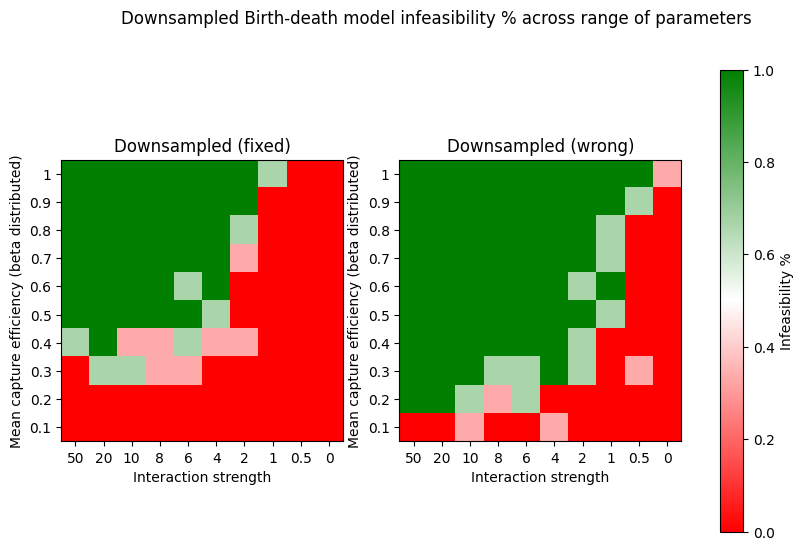

In [12]:
# plot
plot_gridtest_interaction(result_array_new, result_array_old, mean_capture_values, interaction_values)

### Low expression

In [13]:
# gridtest ranges
mean_capture_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
interaction_values = [50, 20, 10, 8, 6, 4, 2, 1, 0.5, 0]
runs = 5

# parameters
rate = 1
cells = 1000

# gridtest
result_array_new, result_array_old = gridtest_interaction(mean_capture_values, interaction_values, runs, rate)

100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


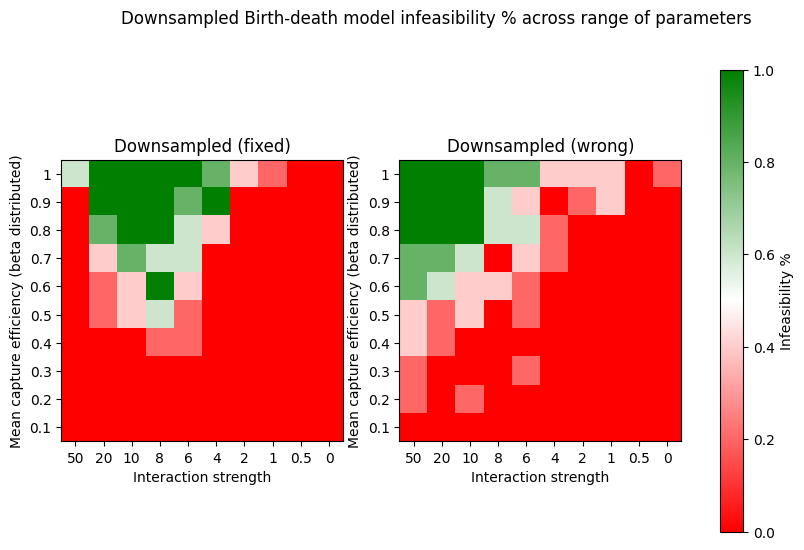

In [14]:
# plot
plot_gridtest_interaction(result_array_new, result_array_old, mean_capture_values, interaction_values)

There is still a large amount of random variation in the results, but overall see similar results for the two constraint sets with the old (wrong) constraints being infeasible slightly more often for lower capture efficiencies.

# Model detection

Simulate telegraph data and test birth death model feasibility using both the old (marginal downsampled CME) and new (joint downsampled CME) constraints to optimize.

Again see that the results are fairly similar, although vary quite a bit run by run due to random sampling.

In [15]:
import pandas as pd
import tqdm
from interaction_inference.dataset import Dataset

In [16]:
def simulate_dataset_range_TE(name, gene_values, cells=1000, interaction=0.0, rate=1, tqdm_disable=True):
    '''
    Produce a dataset of pairs of samples with fixed parameters (rate) over a
    range of gene on values.

    Args:
        cells: number of samples to simulate per gene-pair
        interaction_values: k_reg parameters values to simulate samples for
        rate: k_tx parameter values for all genes

    Returns:
        Dataset instance containing information as attributes

        params_df: pandas dataframe of model parameters per gene-pair
        counts_df: pandas dataframe of sampled counts per gene-pair
    '''

    # number of pairs
    gene_pairs = len(gene_values)

    # dataframes
    params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_on_1', 'k_on_2', 'k_off_1', 'k_off_2', 'k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    # for each gene
    for i in tqdm.tqdm(range(gene_pairs), disable=tqdm_disable):

        # Set reaction rate parameters
        k_on_1 = gene_values[i]
        k_on_2 = gene_values[i]
        k_off_1 = 1 - gene_values[i]
        k_off_2 = 1 - gene_values[i]
        k_tx_1 = rate
        k_tx_2 = rate
        k_deg_1 = 1
        k_deg_2 = 1
        k_reg = interaction

        # store parameters
        params_df.iloc[i] = [k_on_1, k_on_2, k_off_1, k_off_2, k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

        params = {
            'k_on_1': k_on_1,
            'k_on_2': k_on_2,
            'k_off_1': k_off_1,
            'k_off_2': k_off_2,
            'k_tx_1': k_tx_1,
            'k_tx_2': k_tx_2,
            'k_deg_1': k_deg_1,
            'k_deg_2': k_deg_2,
            'k_reg': k_reg
        }

        # simulate sample from model
        sample = simulation.gillespie_telegraph(params, cells)

        # store counts
        counts_df.iloc[i] = sample

    # construct dataset object
    data = Dataset(name)

    # store information
    data.count_dataset = counts_df
    data.param_dataset = params_df
    data.cells = cells
    data.gene_pairs = len(gene_values)
    data.beta = np.array([1.0 for j in range(cells)])

    return data

In [17]:
# simulate sample
data = simulate_dataset_range_TE(
    name = "test",
    gene_values = [1.0, 0.75, 0.5, 0.25, 0.1],
    cells = 1000,
    rate = 1,
    interaction = 0,
    tqdm_disable = False
)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


In [18]:
# downsample
m = 0.9
b = (1 / m) - 1
beta = rng.beta(1, b, size=1000)
data = data.downsample("test", beta)

In [19]:
# bootstrap
data.compute_moments(tqdm_disable=False)
data.bootstrap_probabilities(tqdm_disable=False)
data.compute_fm(tqdm_disable=False)

100%|██████████| 5/5 [00:00<00:00, 15.43it/s]


In [20]:
# construct constraints
constraints = Constraint(
    downsampled_probability = True,
    downsampled_CME         = True,
    k_deg_1                 = True,
    k_reg                   = True
)

# optimize
opt = Optimization(data, constraints, tqdm_disable=True)

Optimization status: OPTIMAL
Runtime: 0.006000041961669922
Optimization status: OPTIMAL
Runtime: 0.006000041961669922
Optimization status: OPTIMAL
Runtime: 0.0009999275207519531
Optimization status: OPTIMAL
Runtime: 0.0
Optimization status: OPTIMAL
Runtime: 0.0


In [21]:
# construct old constraints
constraints = Constraint(
    downsampled_marginal_probability_1 = True,
    downsampled_marginal_probability_2 = True,
    downsampled_marginal_CME_1         = True,
    downsampled_marginal_CME_2         = True,
    k_deg_2                            = True,
    k_deg_1                            = True
)

# optimize
opt = Optimization(data, constraints, tqdm_disable=True)

Optimization status: OPTIMAL
Runtime: 0.007999897003173828
Optimization status: INFEASIBLE
Runtime: 0.01699995994567871
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0
Optimization status: INFEASIBLE
Runtime: 0.0


## Telegraph Gridtest

To get a clearer picture of the difference in results for the two constraint sets, optimize multiple times over a grid of parameter settings: mean capture efficiency and gene-on-rate telegraph parameter:

In [ ]:
def gridtest_telegraph(mean_capture_values, gene_values, runs, rate, cells=1000):

    # result arrays
    result_array_new = np.zeros((len(mean_capture_values), len(gene_values)))
    result_array_old = np.zeros((len(mean_capture_values), len(gene_values)))

    # simulate sample
    data = simulate_dataset_range_TE(
        name = "gridtest",
        gene_values = gene_values * runs,
        cells = cells,
        rate = rate,
        tqdm_disable = False
    )

    # for each capture
    for i, m in enumerate(mean_capture_values):

        print(f"{i + 1} / {len(mean_capture_values)}")

        # beta parameter
        b = (1 / m) - 1

        # capture vector
        if b == 0:
            beta = np.ones(cells)
        else:
            beta = rng.beta(1, b, size=cells)

        # downsample
        data_downsampled = data.downsample("gridtest_downsampled", beta)

        # bootstrap
        data_downsampled.bootstrap_probabilities(tqdm_disable=True)
        data_downsampled.compute_fm(tqdm_disable=True)

        # new constraints
        new_constraints = Constraint(
            downsampled_probability = True,
            downsampled_CME         = True,
            k_deg_1                 = True,
            k_reg                   = True
        )
        
        # old constraints
        old_constraints = Constraint(
            downsampled_marginal_probability_1 = True,
            downsampled_marginal_probability_2 = True,
            downsampled_marginal_CME_1         = True,
            downsampled_marginal_CME_2         = True,
            k_deg_2                            = True,
            k_deg_1                            = True
        )

        # optimize
        opt_new = Optimization(data_downsampled, new_constraints, tqdm_disable=True, print_solution=False)
        opt_old = Optimization(data_downsampled, old_constraints, tqdm_disable=True, print_solution=False)

        # store results
        for j, solution in opt_new.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_array_new[i, j % result_array_new.shape[1]] += 1 / runs

        for j, solution in opt_old.result_dict.items():
            if solution['status'] == "INFEASIBLE":
                result_array_old[i, j % result_array_old.shape[1]] += 1 / runs

    return result_array_new, result_array_old

In [23]:
def plot_gridtest_telegraph(result_array_new, result_array_old, mean_capture_values, gene_values):

    fig, axs = plt.subplots(1, 2, figsize=(10, 6))

    #plt.tight_layout()

    from  matplotlib.colors import LinearSegmentedColormap
    cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 

    vmin, vmax = 0, 1

    # new
    img_new = axs[0].imshow(result_array_new, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[0].set_xlabel("Gene on parameter")
    axs[0].set_xticks(range(len(gene_values)))
    axs[0].set_xticklabels(gene_values)
    axs[0].set_ylabel("Mean capture efficiency (beta distributed)")
    axs[0].set_yticks(range(len(mean_capture_values)))
    axs[0].set_yticklabels(mean_capture_values)
    axs[0].set_title("Downsampled (fixed)")

    # old
    img_old = axs[1].imshow(result_array_old, cmap=cmap, vmin=vmin, vmax=vmax)
    axs[1].set_xlabel("Gene on parameter")
    axs[1].set_xticks(range(len(gene_values)))
    axs[1].set_xticklabels(gene_values)
    axs[1].set_ylabel("Mean capture efficiency (beta distributed)")
    axs[1].set_yticks(range(len(mean_capture_values)))
    axs[1].set_yticklabels(mean_capture_values)
    axs[1].set_title("Downsampled (wrong)")

    fig.suptitle("Downsampled Birth-death model infeasibility % across range of parameters")

    cbar = plt.colorbar(img_new, ax=axs)
    cbar.set_label("Infeasibility %")

### High expression

In [24]:
# gridtest ranges
mean_capture_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
gene_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
runs = 3

# parameters
rate = 5
cells = 1000

# gridtest
result_array_new, result_array_old = gridtest_telegraph(mean_capture_values, gene_values, runs, rate)

100%|██████████| 30/30 [01:43<00:00,  3.46s/it]


1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


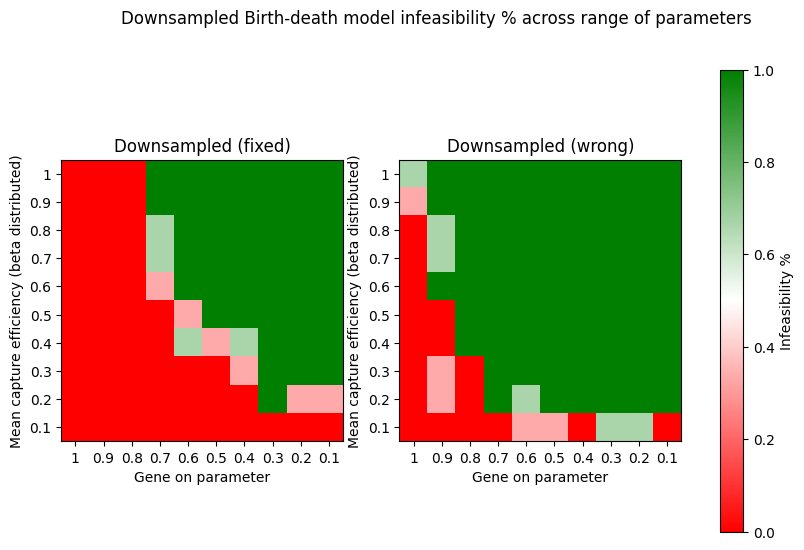

In [25]:
# plot
plot_gridtest_telegraph(result_array_new, result_array_old, mean_capture_values, gene_values)

### Low expression

In [26]:
# gridtest ranges
mean_capture_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
gene_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
runs = 3

# parameters
rate = 1
cells = 1000

# gridtest
result_array_new, result_array_old = gridtest_telegraph(mean_capture_values, gene_values, runs, rate)

100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10
Optimization failed: index 1 is out of bounds for axis 0 with size 1
Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 87, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 135, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 503, in add_constraints
    add_downsampled_CME_constraints(
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 1351, in add_downsampled_CME_constraints
    z == k_deg_1 * pd[1, 0] + \
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1
Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPap

Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 87, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 135, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 510, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 1419, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1


Optimization failed: index 1 is out of bounds for axis 0 with size 1


Traceback (most recent call last):
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 87, in analyse_dataset
    solution_dict[i] = self.optimize(i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\optimization.py", line 135, in optimize
    constraints.add_constraints(self, model, variables, i)
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 510, in add_constraints
    add_downsampled_marginal_CME_1_constraints(
  File "c:\Users\willi\Documents\ProjectPaper\M5R_venv\lib\site-packages\interaction_inference\constraints.py", line 1419, in add_downsampled_marginal_CME_1_constraints
    z == k_deg_1 * pd1[1] - k_tx_1 * fm1[0] * pd1[0],
  File "src\\gurobipy\\mvar.pxi", line 265, in gurobipy._matrixapi.MVar.__getitem__
IndexError: index 1 is out of bounds for axis 0 with size 1


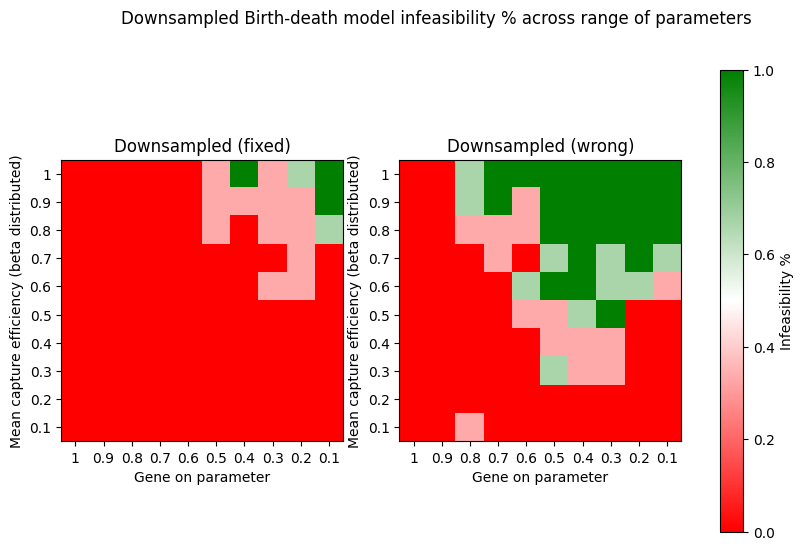

In [27]:
# plot
plot_gridtest_telegraph(result_array_new, result_array_old, mean_capture_values, gene_values)

Again we see a large amount of random variation in the results (repeating with a larger number of runs would reduce this) but overall see a moderate decrease in performance when using the new (weaker, but correct) constraints, with data only being infeasible for higher mean capture.

# Conclusion

There is a decrease in performance when using the new, correct constraints (joint downsampled CME equations rather than marginal).

This is unfortunate, but while the fixed constraints are weaker, they are still able to detect data that does not fit the model (via interaction or telegraph effects) across a variety of parameter values and mean capture efficiencies.

### Notes

- telegraph parameter ranges may lead to very low expression levels, giving a poor indication of real performance (appears worse)?
- need more gridtest runs to reduce random variation